Semantic Image Clustering 

In [27]:
from collections import defaultdict
import random 
import numpy as np 
import tensorflow as tf 
import tensorflow_addons as tfa
import matplotlib.pyplot as plt 

In [2]:
N_CLASS = 10 
RES_SIZE = 32

In [4]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train.shape

(50000, 32, 32, 3)

In [15]:
x_data = np.concatenate([x_train, x_test])
y_data = np.concatenate([y_train, y_test])

In [10]:
# y_train = np.unique(y_train)
# y_train
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [12]:
target_size = 32  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 20  # Number of clusters.
k_neighbours = 5  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

In [20]:
data_preprocessing = tf.keras.Sequential(
    [
    tf.keras.layers.Resizing(RES_SIZE, RES_SIZE), 
    tf.keras.layers.Normalization()
    ]
)

# print(data_preprocessing.layers[-1])
data_preprocessing.layers[-1].adapt(x_data)

In [21]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomTranslation(
            height_factor=(-0.2, 0.2), 
            width_factor=(-0.2, 0.2), 
            fill_mode='nearest'
        ),
        tf.keras.layers.RandomFlip(mode='horizontal'), 
        tf.keras.layers.RandomRotation(factor=0.15, fill_mode='nearest'), 
        tf.keras.layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode='nearest'
        )
    ]
)

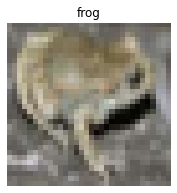

In [23]:
image_idx = np.random.choice(range(x_data.shape[0]))
image = x_data[image_idx]
image_class = classes[y_data[image_idx][0]]

plt.figure(figsize=(3, 3))
plt.imshow(x_data[image_idx].astype('uint8'))
plt.title(image_class)

_ = plt.axis('off')
                              

In [24]:
def create_encoder(representation_dim): 
    encoder = tf.keras.Sequential(
        [
            tf.keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling='avg'
            ), 
            tf.keras.layers.Dense(representation_dim)
            
        ]
    )
    
    return encoder

In [35]:
class RepresentationLearner(tf.keras.Model):
    def __init__(self, encoder, projection_units, num_agumentation, temperature=1.0, dropout_rate=0.1, l2_normlization=False, **kwargs):
        
        super(RepresentationLearner, self).__init__(**kwargs) 
        self.encoder = encoder
        
        self.projector = tf.keras.Sequential(
            [
                tf.keras.layers.Dropout(dropout_rate), 
                tf.keras.layers.Dense(units=projection_units, use_bias=False), 
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.ReLU()
            ]
        )
        
        self.num_agumentation = num_agumentation
        self.temperature = temperature 
        self.l2_normlization = l2_normlization 
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')
        
        
    @property
    def metrics(self): 
        return [self.loss_tracker]
    
    def compute_contrastive_loss(self, feature_vectors, batch_size): 
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        
        if self.l2_normlization:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
            
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b = True) / self.temperature
        )
        
        logits_max = tf.math.reduce_max(logits, axis=1)
        
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        
        return tf.keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        
    def call(self, inputs):
        preprocessed = data_preprocessing(inputs)
        
        augmented = [] 
        
        for _ in range(self.num_agumentation): 
            augmented.append(data_augmentation(preprocessed))
            
        augmented = tf.keras.layers.Concatenate(axis=0)(augmented)
        
        features = self.encoder(augmented)
        
        return self.projector(features)
    
    def train_step(self, inputs): 
        batch_size = tf.shape(inputs)[0]
        
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True) 
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
            
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(loss)
        
        return {m.name : m.result() for m in self.metrics}
    
    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False) 
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)    
        self.loss_tracker.update_state(loss)
        
        return {'loss' : self.loss_tracker.result()}

In [38]:
encoder = create_encoder(representation_dim)

representation_learner = RepresentationLearner(
    encoder, projection_units, num_agumentation=2, temperature=0.1
)

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)

representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_schedule,
                                   weight_decay=0.0001)
)

hist = representation_learner.fit(
    x = x_data, 
    batch_size=512, 
    epochs=50
)

Epoch 1/50
118/118 [==============================] - 48s 265ms/step - loss: 263.2459
Epoch 2/50
118/118 [==============================] - 29s 249ms/step - loss: 420.4306
Epoch 3/50
118/118 [==============================] - 30s 256ms/step - loss: 449.9218
Epoch 4/50
118/118 [==============================] - 30s 253ms/step - loss: 374.3980
Epoch 5/50
118/118 [==============================] - 30s 253ms/step - loss: 330.7078
Epoch 6/50
118/118 [==============================] - 30s 252ms/step - loss: 305.4851
Epoch 7/50
118/118 [==============================] - 29s 247ms/step - loss: 298.2275
Epoch 8/50
118/118 [==============================] - 30s 255ms/step - loss: 294.8601
Epoch 9/50
118/118 [==============================] - 30s 255ms/step - loss: 284.5606
Epoch 10/50
118/118 [==============================] - 30s 255ms/step - loss: 254.2688
Epoch 11/50
118/118 [==============================] - 30s 255ms/step - loss: 279.0839
Epoch 12/50
118/118 [==============================]